In [412]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# suprimir future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def normalize_string_column_values(df, column_name):
    df[column_name] = df[column_name].str.upper()
    df[column_name] = df[column_name].str.strip()
    return df

def normalize_category_column_values(df, column_names):
    for column_name in column_names:
        df = normalize_string_column_values(df, column_name)
        df[column_name] = df[column_name].astype('category')
    return df

### Limpieza

#### Orders

In [413]:
orders = pd.read_csv(
    'data/orders.csv',
    usecols=[
        'order_id',
        'customer_id',
        'order_date',
        'status',
        'payment_method',
        'discount_amount',
        'tax_amount',
        'total_amount',
        'currency',
    ],
    dtype={
        'order_id': 'uint32',
        'customer_id': 'uint32',
        'total_amount': 'float32',
        'tax_amount': 'float32',
        'discount_amount': 'float32',
    },
)

In [414]:
orders = normalize_category_column_values(
    orders, ['status', 'payment_method', 'currency']
)
orders.fillna({'discount_amount': 0, 'tax_amount': 0, 'total_amount': 0}, inplace=True)

orders["order_date"] = pd.to_datetime(orders["order_date"], format="%Y-%m-%dT%H:%M:%S.%f", errors="coerce")
orders["date"] = pd.DatetimeIndex(orders["order_date"]).date
orders.drop(columns=["order_date"], inplace=True)

#### Customers

In [415]:
customers = pd.read_csv(
    'data/customers.csv',
    usecols=[
        'customer_id',
        'address',
        'is_active',
        'customer_segment',
    ],
    dtype={
        'customer_id': 'uint32',
        'address': 'string',
        'is_active': 'boolean',
        'customer_segment': 'string',
    }
)

In [416]:
customers.fillna({'address': 'UNDEFINED', 'customer_segment': 'UNDEFINED'}, inplace=True)
customers = normalize_category_column_values(customers, ['customer_segment'])

customers["address"] = customers["address"].str.upper()
pattern = r'([A-Z]{2})\s\d{5}'
customers["state"] = customers["address"].str.extract(pattern)
customers.state = customers.state.astype('category')
customers.drop(columns=["address"], inplace=True)

#### Reviews

In [417]:
reviews = pd.read_csv(
    'data/reviews.csv',
    usecols=[
        'review_id',
        'customer_id',
        'product_id',
        'rating',
    ],
    dtype={
        'review_id': 'uint32',
        'customer_id': 'uint32',
        'product_id': 'uint32',
    }
)
# como solo voy a usar rating, no me interesa la review si no tiene rating
reviews.dropna(subset=['rating'], inplace=True)
reviews['rating'] = reviews['rating'].astype('uint8') # ratings van del 1 al 5, alcanza con uint8

#### Products

In [418]:
products = pd.read_csv(
    'data/products.csv',
    usecols=[
        'product_id',
        'stock_quantity',
        'category_id',
        'weight_kg',
        'price',
        'is_active',
    ],
    dtype={
        'product_id': 'uint32',
        'category_id': 'uint32',
        'is_active': 'boolean',
    }
)
products.fillna({'stock_quantity': 0}, inplace=True) # asumo que si no tiene stock_quantity es porque no tiene stock
products['stock_quantity'] = products['stock_quantity'].astype('uint32')
products['weight_kg'] = products['weight_kg'].astype('float32')
products['price'] = products['price'].astype('float32')

#### Order Items

In [419]:
items = pd.read_csv(
    'data/order_items.csv',
    usecols=[
        'order_item_id',
        'product_id',
        'quantity',
        'unit_price',
        'line_total',
        'discount_amount',
    ],
    dtype={
        'order_item_id': 'uint32',
        'product_id': 'uint32',
    }
)
# Intento deducir los quantity faltantes a partir de line_total y unit_price
print(f"Cantidad de nulos antes de deducir quantity: {items['quantity'].isna().sum()}")
mask = items['quantity'].isna() & items['line_total'].notna() & items['unit_price'].notna() & (items['unit_price'] != 0)
items.loc[mask, 'quantity'] = items.loc[mask, 'line_total'] / items.loc[mask, 'unit_price']

print(f"Cantidad de nulos después de deducir quantity: {items['quantity'].isna().sum()}")
items.dropna(subset=['quantity'], inplace=True) # descarto los que no pude deducir quantity
items.drop(columns=['line_total', 'unit_price'], inplace=True)
items['quantity'] = items['quantity'].astype('uint32')
items['discount_amount'] = items['discount_amount'].astype('float32')


Cantidad de nulos antes de deducir quantity: 42786
Cantidad de nulos después de deducir quantity: 11847


#### Inventory

In [420]:
inventory = pd.read_csv(
    'data/inventory_logs.csv',
    usecols=[
        'log_id',
        'product_id',
        'quantity_change',
        'reason',
    ],
    dtype={
        'log_id': 'uint32',
        'product_id': 'uint32',
    }
)
inventory.dropna(subset=['quantity_change'], inplace=True)
inventory['quantity_change'] = inventory['quantity_change'].astype('int32')
inventory = normalize_string_column_values(inventory, 'reason')

#### Categories

In [421]:
categories = pd.read_csv(
    'data/categories.csv',
    usecols=[
        'category_id',
        'category_name',
        'parent_category'
    ],
    dtype={
        'category_id': 'uint32',
    }
)
categories = normalize_category_column_values(
    categories, ['category_name', 'parent_category']
)

### 1. Evolución del ingreso neto a lo largo del tiempo.
Considero "ingreso neto" como suma de total_amount – descuentos – impuestos, solo para los ingresos en dólares.

In [422]:
orders_grouped = orders.loc[orders.currency == "USD"].groupby("date")[["total_amount", "discount_amount", "tax_amount"]].sum()
orders_grouped["net_income"] = orders_grouped["total_amount"] - orders_grouped["discount_amount"] - orders_grouped["tax_amount"]
orders_grouped.reset_index(inplace=True)

Text(0, 0.5, 'Ingreso Neto (USD)')

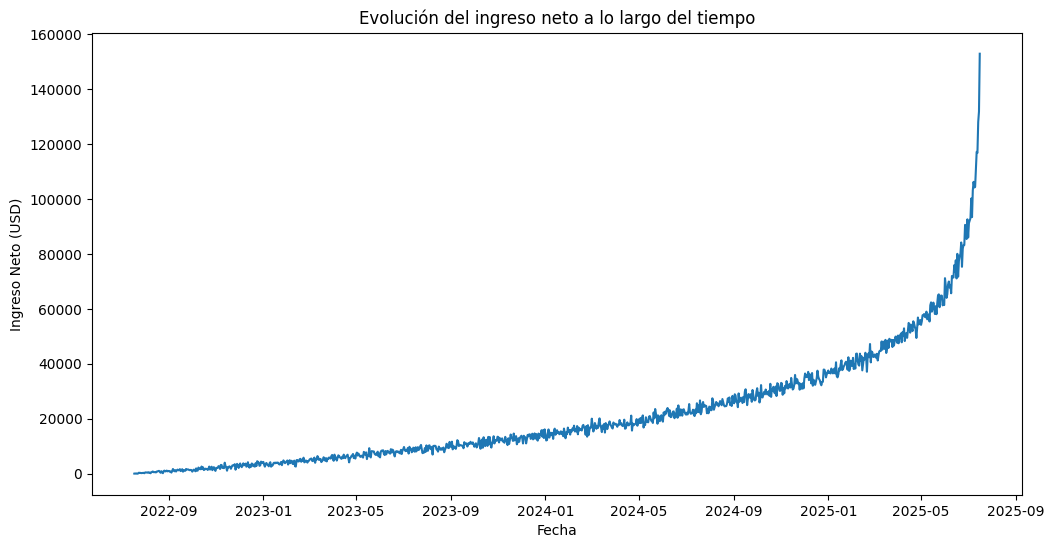

In [423]:
import datetime
limit_date = datetime.date(2025, 7, 17) # fecha del último dato en el dataset, no representativo
plt.figure(figsize=(12, 6))
sns.lineplot(data=orders_grouped.loc[orders_grouped.date != limit_date], x="date", y="net_income")
plt.title("Evolución del ingreso neto a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Ingreso Neto (USD)")

In [424]:
del orders_grouped
del limit_date

### 2. Cantidad de dólares gastados por método de pago por clientes activos con direcciones militares
Se considera que un usuario tiene una "dirección militar" si su estado es AA, AE o AP.

In [443]:
military_states = ['AA', 'AE', 'AP']
active_military_customers = customers[(customers['is_active']) & (customers['state'].isin(military_states))]['customer_id'].reset_index()
active_military_orders = orders.loc[orders.currency == "USD"].merge(active_military_customers, on='customer_id', how='inner')
payment_method_sum = active_military_orders.groupby('payment_method')['total_amount'].sum().reset_index()

Text(0, 0.5, 'Dólares Gastados')

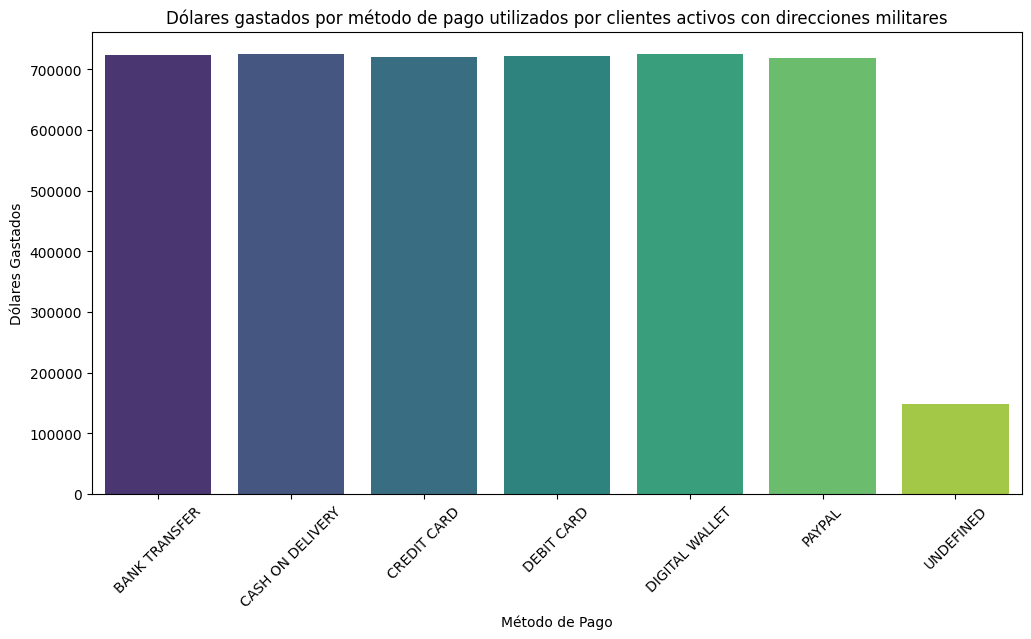

In [444]:
plt.figure(figsize=(12, 6))
sns.barplot(data=payment_method_sum, x="payment_method", y="total_amount", palette="viridis")
plt.title("Dólares gastados por método de pago utilizados por clientes activos con direcciones militares")
plt.xticks(rotation=45)
plt.xlabel("Método de Pago")
plt.ylabel("Dólares Gastados")

In [427]:
del military_states
del active_military_customers
del active_military_orders
del payment_method_sum

### 3. Distribución de calificaciones según segmento de cliente.

In [428]:
reviews = reviews.merge(customers[['customer_id', 'customer_segment']], on='customer_id', how='left')
reviews.fillna({'customer_segment': 'UNDEFINED'}, inplace=True)
data = reviews.groupby('customer_segment')['rating'].value_counts(normalize=True).unstack()

<Figure size 1200x600 with 0 Axes>

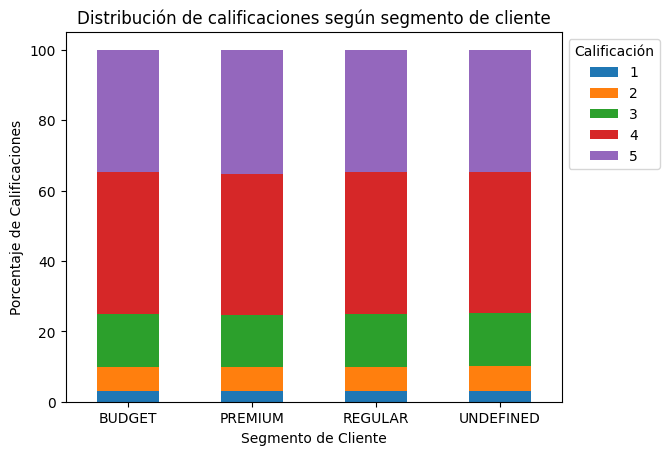

In [429]:
plt.figure(figsize=(12, 6))
data *= 100 # paso a porcentaje
data.plot(kind='bar', stacked=True)
plt.title("Distribución de calificaciones según segmento de cliente")
plt.xlabel("Segmento de Cliente")
plt.ylabel("Porcentaje de Calificaciones")
plt.xticks(rotation=0)
plt.legend(title='Calificación', bbox_to_anchor=(1, 1), loc='upper left')

### 4. Relación entre stock disponible y cantidad de órdenes por producto

Text(0, 0.5, 'Cantidad de unidades ordenadas')

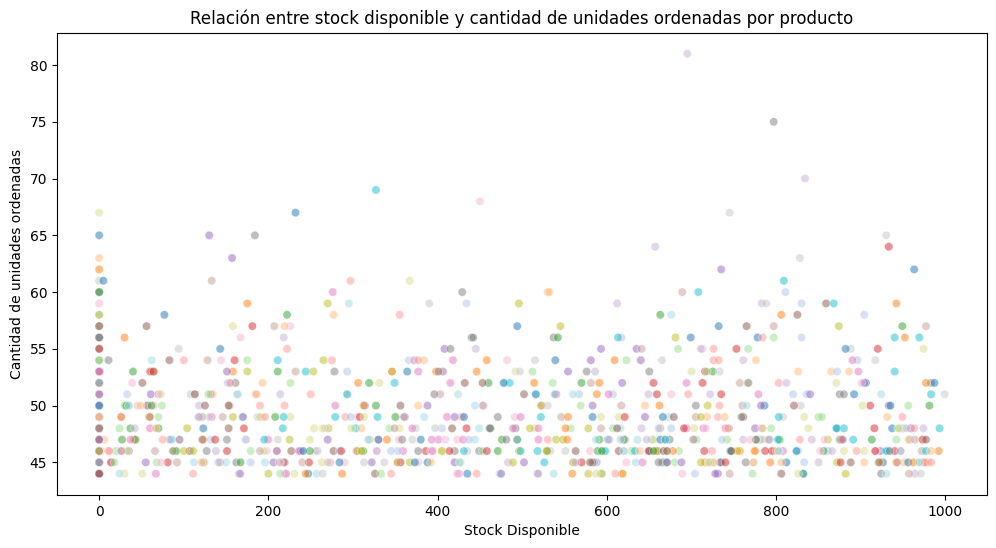

In [ ]:
order_items_count_by_product = items.groupby('product_id')['quantity'].sum().reset_index().nlargest(1000, 'quantity')
data = order_items_count_by_product.merge(products[['product_id', 'stock_quantity']], on='product_id', how='left')
plt.figure(figsize=(12, 6))
sns.scatterplot(data, x='stock_quantity', y='quantity', hue='product_id', alpha=0.5, legend=False, palette='tab20')
plt.title("Relación entre stock disponible y cantidad de unidades ordenadas por producto")
plt.xlabel("Stock Disponible")
plt.ylabel("Cantidad de unidades ordenadas")


In [ ]:
del order_items_count_by_product

### 5. Rating promedio por categoría padre y segmento de cliente

In [431]:
reviews = reviews.merge(products[['product_id', 'category_id']], on='product_id', how='left')
reviews = reviews.merge(categories[['category_id', 'parent_category']], on='category_id', how='left')
data = reviews.groupby(['parent_category', 'customer_segment'])['rating'].mean().unstack()

Text(120.7222222222222, 0.5, 'Categoría Padre')

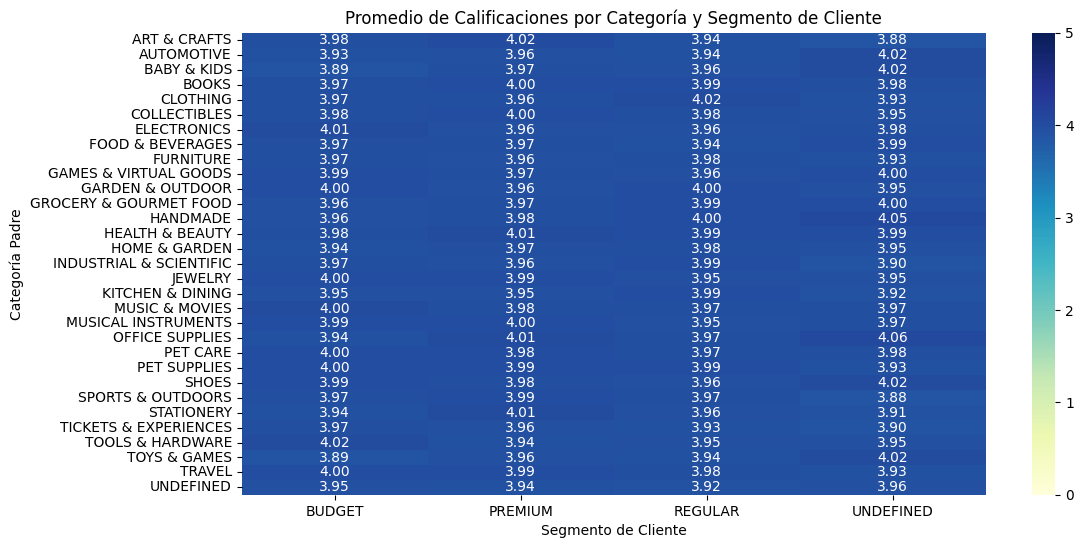

In [432]:
plt.figure(figsize=(12, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0, vmax=5)
plt.title("Promedio de Calificaciones por Categoría y Segmento de Cliente")
plt.xlabel("Segmento de Cliente")
plt.ylabel("Categoría Padre")

Text(120.7222222222222, 0.5, 'Categoría Padre')

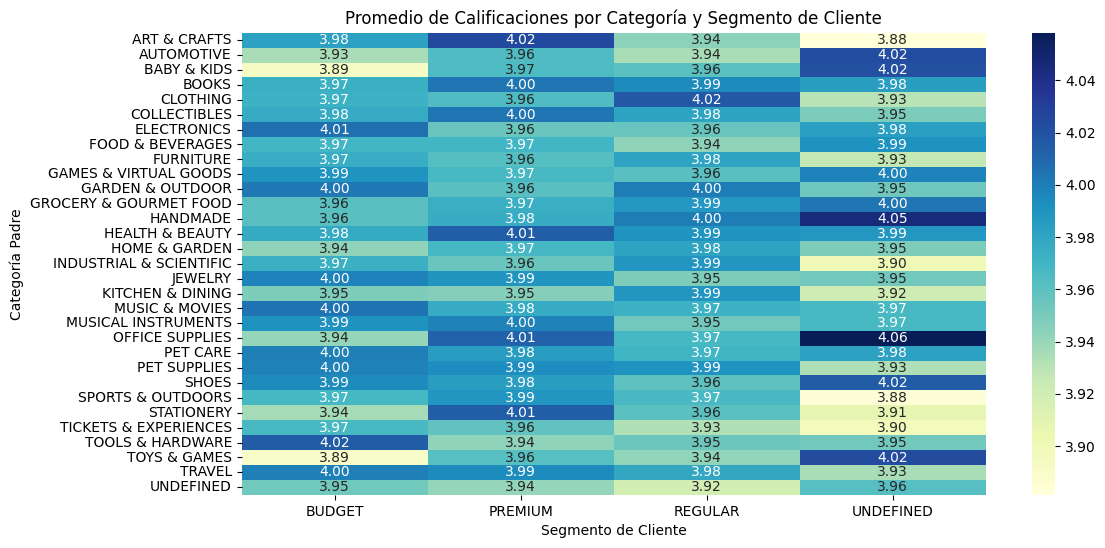

In [433]:
plt.figure(figsize=(12, 6))
sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Promedio de Calificaciones por Categoría y Segmento de Cliente")
plt.xlabel("Segmento de Cliente")
plt.ylabel("Categoría Padre")

### 6. Relación entre precio del productos activos y rating promedio

In [434]:
active_products = products[products['is_active']]
data = reviews.groupby('product_id')['rating'].mean().reset_index()
data = data.merge(active_products[['product_id', 'price']], on='product_id', how='left')

Text(0, 0.5, 'Rating Promedio')

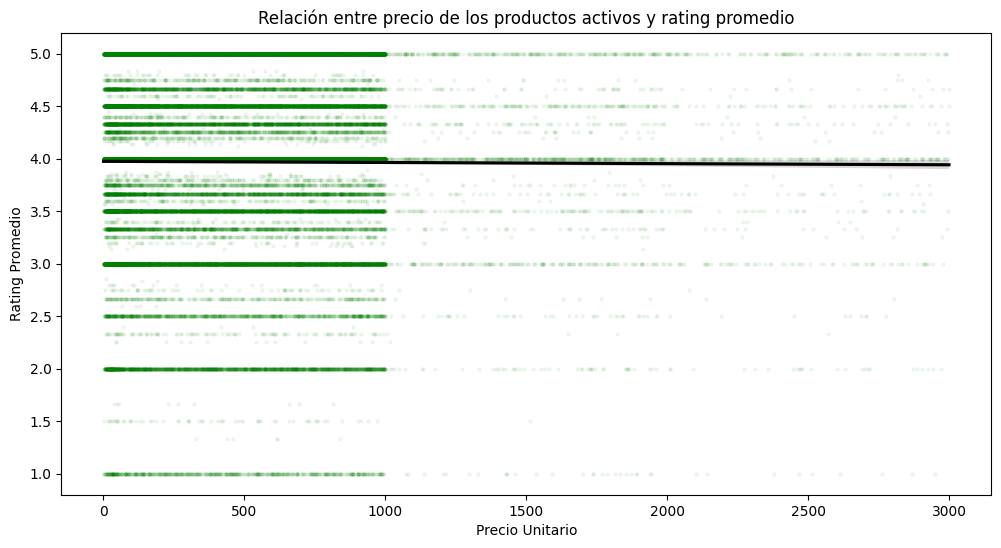

In [435]:
plt.figure(figsize=(12, 6))
sns.regplot(
    data,
    x='price',
    y='rating',
    scatter_kws={'alpha': 0.05, 'color': 'green', 's': 5},
    line_kws={'color': 'black'}
)
plt.title("Relación entre precio de los productos activos y rating promedio")
plt.xlabel("Precio Unitario")
plt.ylabel("Rating Promedio")

### 7. Distribución del descuento para las 5 categorías de producto más vendidas.

In [436]:
items_categories = items.merge(products[['product_id', 'category_id']], on='product_id', how='left')[['product_id', 'category_id', 'quantity', 'discount_amount']]
top_5_categories = items_categories.groupby('category_id')['quantity'].sum().nlargest(5)
items_categories = items_categories[items_categories['category_id'].isin(top_5_categories.index)]
items_categories['unit_discount'] = items_categories['discount_amount'] / items_categories['quantity']

In [437]:

categories_names = categories[['category_id', 'category_name']].loc[categories['category_id'].isin(top_5_categories.index)].reset_index()
category_name_map = {}
for _, row in categories_names.iterrows():
    category_name_map[row['category_id']] = row['category_name']
items_categories['category_id'] = items_categories['category_id'].map(category_name_map)
items_categories.rename(columns={'category_id': 'category_name'}, inplace=True)
items_categories.fillna({'discount_amount': 0}, inplace=True) # asumo que si el valor es nulo es porque no hubo descuento

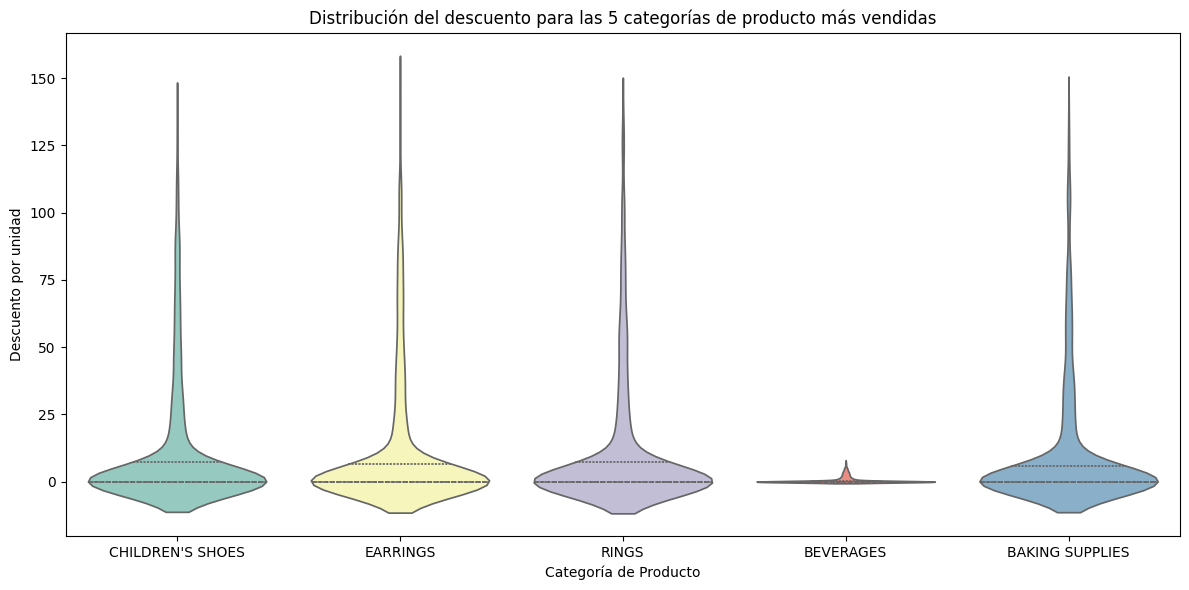

In [438]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=items_categories,
    x='category_name', y='unit_discount', palette='Set3', inner='quartile'
)
plt.ylabel("Descuento por unidad")
plt.title("Distribución del descuento para las 5 categorías de producto más vendidas")
plt.xlabel("Categoría de Producto")
plt.tight_layout()
plt.show()

### 8. Unidades de productos robados por categoría y subcategoría de producto
Suposición: para que un producto se considere "robado", debe tener razón 'theft' y tener una 'quantity_change' menor a cero.

In [439]:
returned_orders = inventory[inventory['reason'] == 'THEFT'][inventory['quantity_change'] < 0][['quantity_change', 'product_id']]
returned_orders = returned_orders.merge(products[['product_id', 'category_id']], on='product_id')
returned_orders = returned_orders.merge(categories[['category_id', 'category_name', 'parent_category']], on='category_id')[['quantity_change', 'category_name', 'parent_category']]
returned_orders.dropna(inplace=True)
returned_orders = returned_orders.groupby(['parent_category', 'category_name'])['quantity_change'].sum().reset_index()
returned_orders = returned_orders.loc[returned_orders['quantity_change'] < 0]
returned_orders['quantity_change'] = returned_orders['quantity_change'].abs()

C:\Users\Patricio\AppData\Local\Temp\ipykernel_26156\2410703333.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [440]:
import plotly.express as px
fig = px.treemap(
    returned_orders,
    path=['parent_category', 'category_name'],
    values='quantity_change',
    title='Unidades robadas por categoría y subcategoría de producto'
)
fig.update_layout(width=1200, height=600)
fig.update_traces(marker=dict(cornerradius=5))
fig.show()

Solo por curiosidad, agrego este último gráfico. Es una alternativa al treemap que me gustó.
No lo agregué en el informe porque al haber tantas categorías no se ve muy bien.

In [441]:
fig = px.sunburst(
    returned_orders,
    path=['parent_category', 'category_name'],
    values='quantity_change',
    title='Unidades robadas por categoría y subcategoría de producto'
)
fig.update_layout(width=1200, height=600)
fig.show()